# 🏠 Graph-Stop Home Hunter — Guided Notebook Tour

This notebook is a **hands-on companion** to the codebase (`graph_home_hunter.py`).  
You’ll train, evaluate, and *peek inside* a three-stage pipeline that turns raw real-estate listings into **actionable buy/​wait advice**.

| Stage | What you’ll do | Why it matters |
|-------|----------------|----------------|
| **1 Graph Encoder** | Train a 2-layer **GAT** (or swap in GraphSAGE) on a **buyer → listing → suburb** graph. | Captures relational cues—price clusters, suburb similarity, CBD distance—that flat features miss. |
| **2 Tabular Head** | Feed embeddings + **one-hot features** through a Gaussian NB or Logistic Reg head, optionally keeping only the top-k features by mutual information. | Blends learned context with interpretable/calibrated probabilities. |
| **3 Decision Logic** | Apply a threshold **τ** and a **Bayesian Option-Value Planner** (wait-cost vs regret-cost δ) to decide *“Bid now”* vs *“Hold for better stock.”* | Converts probabilities into real decisions, balancing confidence against future opportunity. |

### Notebook flow 🚦
1. **Synthetic data** Generate or load 10 weekly CSV snapshots **plus** a larger train/test table.  
2. **Train & validate** • Graph-only GNN • Stacked head with calibration.  
3. **Threshold sweep** Find the F1-optimal τ (or F-β for a precision/recall tilt).  
4. **Week-by-week simulation** Replay snapshots and watch the Option-Value Planner decide when to pull the trigger.  
5. **Explainability** Inspect per-listing feature contributions to understand each recommendation.

Ready? Let’s hunt some homes 🔑🏡


In [23]:
import os, sys, math, random, copy, json, itertools, types, warnings, joblib, subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch, torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GATConv

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import mutual_info_classif

# local source (assumes notebook lives next to graph_home_hunter.py)
from graph_home_hunter import (
    ListingGraphTG, GCN, IntentHead, GraphTrainer,
    Metrics, _safe_torch_load, set_seed
)

# put this once, near the top of the notebook
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

set_seed(42)
print(torch.__version__)

2.3.0+cu118


## 1. Prepare synthetic training & test CSVs

In [2]:
# If the CSVs don’t exist yet, generate them with make_training_data_v3.py
if not Path('train_listings.csv').exists():
    !python make_training_data_v3.py

df_train = pd.read_csv('train_listings.csv')
df_test  = pd.read_csv('test_listings.csv')
print(df_train.shape, df_test.shape)
df_train.head()

(16000, 19) (4000, 19)


,id,asking_price,body_corp,internal_m2,balcony_m2,beds,suburb,livability,condition,has_cladding,travel_time_mins,sold_date,has_parking,has_storage,has_solar,north_facing,near_shops,outdoor_space,label
0,10651,634000,1809,74,1.0,2,Footscray,10,new,False,5,NaN,NaN,False,False,False,False,False,0
1,2042,557000,1894,86,17.7,2,Sunbury,9,good,False,61,NaN,False,True,False,False,True,False,0
2,8669,601000,1406,109,17.7,3,Werribee,8,good,False,45,NaN,False,NaN,NaN,False,True,True,0
3,1115,616000,2517,116,8.2,2,Footscray,10,good,False,14,NaN,True,False,False,True,False,True,0
4,13903,639000,2303,84,6.6,2,Richmond,16,new,False,21,NaN,False,False,False,NaN,True,False,0


## 2. Build a PyG graph from the training CSV

Positives: 920   Negatives: 15080


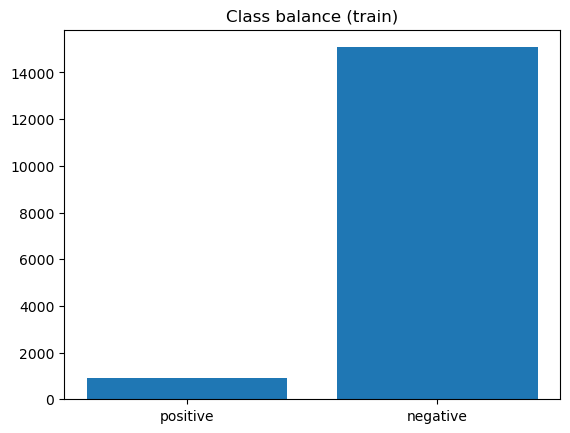

In [3]:
g_train = ListingGraphTG().from_csv('train_listings.csv')
pos = int(g_train.y[g_train.listing_idx].sum())
neg = len(g_train.listing_idx) - pos
print(f'Positives: {pos}   Negatives: {neg}')

plt.bar(['positive','negative'], [pos,neg])
plt.title('Class balance (train)')
plt.show()

## 3. Train the GNN encoder

In [4]:
ckpt = Path("gnn_v1.pt")

if ckpt.exists():
    print("✅ found", ckpt, "— loading checkpoint …")
    gnn = GCN(); gnn.load(ckpt); gnn.eval()
else:
    print("⏳ checkpoint not found — training from scratch …")
    !python graph_home_hunter.py --train-graph train_graph.pt gnn_v1.pt --epochs 150 --patience 50 --lr 1e-3
    gnn = GCN(); gnn.load(ckpt); gnn.eval()

✅ found gnn_v1.pt — loading checkpoint …


## 4. Pure‑GNN performance on the held‑out test set

In [5]:
g_test = ListingGraphTG().from_csv('test_listings.csv', add_masks=False)
with torch.no_grad():
    prob_gnn = torch.sigmoid(gnn(g_test)).numpy()[g_test.listing_idx]
pred_gnn = (prob_gnn>=0.5).astype(int)
Metrics.report('GNN only', g_test.y[g_test.listing_idx].int().numpy(), pred_gnn)

GNN only acc=0.953  prec=0.57  rec=0.87  f1=0.69
confusion: TP 207 | FP 157 | FN 30 | TN 3606


## 5. Train tabular head on top of frozen GNN embeddings

In [6]:
head_ckpt = Path("logreg_head.pkl")

if head_ckpt.exists():
    print("✅ found", head_ckpt, "— loading calibrated head …")
else:
    print("⏳ head checkpoint not found — training now …")
    !python graph_home_hunter.py --train-stack train_listings.csv gnn_v1.pt logreg_head.pkl --stack-model logreg --calib sigmoid

head = IntentHead.load(head_ckpt)

✅ found logreg_head.pkl — loading calibrated head …


## 6. Stacked model performance

In [7]:
!python graph_home_hunter.py --predict-stack test_listings.csv gnn_v1.pt logreg_head.pkl

stack metrics:
stack acc=0.991  prec=0.94  rec=0.90  f1=0.92
confusion: TP 213 | FP 14 | FN 24 | TN 3749

OVP decision:  💰  **PLACE OFFER NOW**
  • current best posterior  : 0.999
  • P(better next week)     : 0.68%
  • Δ(Expected regret)      : -0.0193


## 7. Model architecture schematic

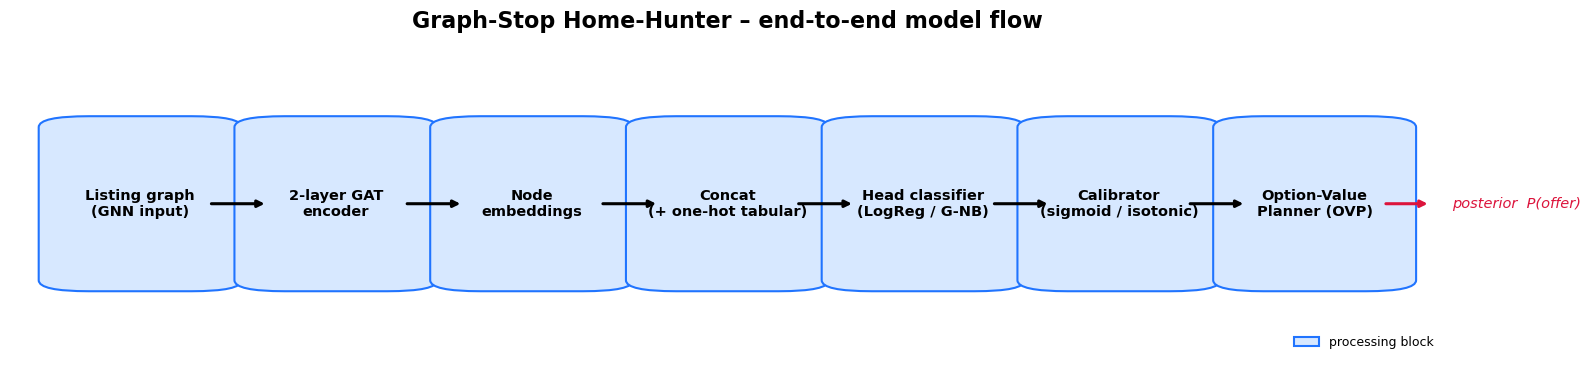

In [21]:
labels = [
    "Listing graph\n(GNN input)",
    "2-layer GAT\nencoder",
    "Node\nembeddings",
    "Concat\n(+ one-hot tabular)",
    "Head classifier\n(LogReg / G-NB)",
    "Calibrator\n(sigmoid / isotonic)",
    "Option-Value\nPlanner (OVP)"
]

# ─── styling ----------------------------------------------------
FACE, EDGE = "#d7e8ff", "#2074ff"
fs_title, fs_lbl = 16, 10.5
h_pad, v_pad = 0.04, 0.24          # figure-side padding
gap = 0.035                        # gap between blocks
arrow_kw       = dict(arrowstyle="-|>", lw=2.2, color="black")
arrow_final_kw = dict(arrowstyle="-|>", lw=2.2, color="crimson")

# ─── geometry ---------------------------------------------------
n = len(labels)
avail_w = 1 - 2 * h_pad
box_w   = (avail_w - gap * (n - 1)) / n
box_h   = 1 - 2 * v_pad
y0      = v_pad                    # bottom of blocks

fig, ax = plt.subplots(figsize=(16, 3.8))
ax.axis("off")
ax.set_title("Graph-Stop Home-Hunter – end-to-end model flow",
             fontsize=fs_title, fontweight="bold", pad=14)

centres = []

# ─── blocks -----------------------------------------------------
for i, txt in enumerate(labels):
    x0 = h_pad + i * (box_w + gap)
    centres.append(x0 + box_w / 2)

    ax.add_patch(
        mpatches.FancyBboxPatch(
            (x0, y0), box_w, box_h,
            boxstyle="round,pad=0.02,rounding_size=0.035",
            facecolor=FACE, edgecolor=EDGE, linewidth=1.5
        )
    )
    ax.text(x0 + box_w / 2, y0 + box_h / 2, txt,
            ha="center", va="center", fontsize=fs_lbl, fontweight="bold")

# ─── internal arrows (black) -----------------------------------
for cL, cR in zip(centres[:-1], centres[1:]):
    ax.annotate("",
        xy=(cR - box_w / 2 + 0.003, 0.5),
        xytext=(cL + box_w / 2 - 0.003, 0.5),
        arrowprops=arrow_kw
    )

# ─── final crimson arrow inside axes ---------------------------
right_edge_OVP = centres[-1] + box_w / 2
tail = (right_edge_OVP - 0.003, 0.5)
head = (min(0.99, right_edge_OVP + 0.03), 0.5)  # keep head ≤ 0.99
ax.annotate("",
    xy=head, xytext=tail,
    arrowprops=arrow_final_kw,
    annotation_clip=False           # draw even if head slightly outside
)

# ─── posterior label -------------------------------------------
ax.text(head[0] + 0.015, 0.5, "posterior  P(offer)",
        fontsize=fs_lbl, va="center", fontstyle="italic", color="crimson")

# ─── legend -----------------------------------------------------
legend_patch = mpatches.FancyBboxPatch((0, 0), 1, 1,
                                       boxstyle="round,pad=0.02",
                                       facecolor=FACE, edgecolor=EDGE,
                                       linewidth=1.5)
ax.legend([legend_patch], ["processing block"],
          loc="lower right", frameon=False, fontsize=9)

plt.tight_layout()
plt.show()



## 8. Week‑by‑week simulation

In [9]:
!python simulate_weeks.py --gnn gnn_v1.pt --head logreg_head.pkl --thr 0.95 --wait-cost 0.02 --regret-cost 0.2 week_0.csv week_1.csv week_2.csv week_3.csv week_4.csv week_5.csv week_6.csv week_7.csv week_8.csv week_9.csv


🏠  Week 0: c:\Users\User\anaconda3\python.exe graph_home_hunter.py --predict-stack week_0.csv gnn_v1.pt logreg_head.pkl --thr 0.95 --wait-cost 0.02 --regret-cost 0.2 --k-next-week 10 --quiet-metrics


OVP decision:  ⏳  WAIT
  • current best posterior  : 0.747
  • P(better next week)     : 17.13%
  • Δ(Expected regret)      : +0.0143

🏠  Week 1: c:\Users\User\anaconda3\python.exe graph_home_hunter.py --predict-stack week_1.csv gnn_v1.pt logreg_head.pkl --thr 0.95 --wait-cost 0.02 --regret-cost 0.2 --k-next-week 10 --quiet-metrics


OVP decision:  ⏳  WAIT
  • current best posterior  : 0.747
  • P(better next week)     : 17.12%
  • Δ(Expected regret)      : +0.0142

🏠  Week 2: c:\Users\User\anaconda3\python.exe graph_home_hunter.py --predict-stack week_2.csv gnn_v1.pt logreg_head.pkl --thr 0.95 --wait-cost 0.02 --regret-cost 0.2 --k-next-week 10 --quiet-metrics


OVP decision:  ⏳  WAIT
  • current best posterior  : 0.747
  • P(better next week)     : 17.11%
  • Δ(Expected regret)      : 

## 9. Explain why the best listing was chosen in Week 8

In [10]:
!python graph_home_hunter.py --predict-stack week_8.csv gnn_v1.pt logreg_head.pkl --thr 0.95 --explain-id 161

stack metrics:
stack acc=0.972  prec=1.00  rec=0.17  f1=0.29
confusion: TP 1 | FP 0 | FN 5 | TN 175

OVP decision:  ⏳  WAIT
  • current best posterior  : 0.954
  • P(better next week)     : 26.94%
  • Δ(Expected regret)      : +0.0069

Top feature contributions for listing 161:
  near_shops_True           +4.516
  condition_new             +3.104
  north_facing_True         +0.343
  outdoor_space_True        -0.312
  has_storage_False         -0.236


## 10. Run the Streamlit GUI (opens a browser tab) 

### To run the interactive simulations in the GUI, please upload: 
1) The model: gnn_v1.pt
2) The model head: logreg_head.pkl and 
3) The mock weekly listings data: week0-9.csv files 

In [11]:
!streamlit run home_hunter_app.py

^C
